# MNIST Handwritten Digit Recognition
Depends on MNIST in CSV format: http://yann.lecun.com/exdb/mnist/
    


In [1]:
#imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from keras.utils import to_categorical, normalize
from keras.layers.normalization import BatchNormalization
from keras.constraints import maxnorm

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
#!ls
#!pwd
#!ls ..
#!ls ../input
#example_file = "../input/sample_submission.csv"
#df = pd.read_csv(example_file)
#print(df.head())

In [3]:
#constants
#base_path = '../input/'
base_path = ''
train_file = base_path + 'train.csv'
test_file = base_path + 'test.csv'

num_classes = 10
dev_set_fraction = 0.05

w = 28
h = 28
c = 1

droprate = 0.2
learning_rate = 0.001

In [4]:
#explore
df = pd.read_csv(train_file)
print(df.head())
print("shape: " + str(df.shape))
df.describe()

dft = pd.read_csv(test_file)
print(dft.head())
print("shape: " + str(dft.shape))
dft.describe()


   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0         

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,...,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.0,28000.0,28000.0,28000.0,28000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.164607,0.073214,0.028036,0.011250,0.006536,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.473293,3.616811,1.813602,1.205211,0.807475,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,254.000000,193.000000,187.000000,119.000000,0.0,0.0,0.0,0.0,0.0


In [5]:
# extract
df = pd.read_csv(train_file)

m = df.shape[0]
pixelnum = df.shape[1]-1

# randomize so we can split again to get a dev set
df = df.sample(frac=1).reset_index(drop=True)

x_train = df.iloc[:, 1:pixelnum+1].values
y_train = to_categorical(df['label'].values, num_classes=10)

x_train = normalize(x_train)

split = int(m - m*dev_set_fraction)
x = x_train[:split, :]
y = y_train[:split, :]
x_dev = x_train[split:, :]
y_dev = y_train[split:, :]

dftest = pd.read_csv(test_file)
x_test = normalize(dftest.values)

print("x: {}, y: {}".format(x.shape, y.shape))
print("x_dev: {}, y_dev: {}".format(x_dev.shape, y_dev.shape))
print("x_test: {}".format(x_test.shape))

x: (39900, 784), y: (39900, 10)
x_dev: (2100, 784), y_dev: (2100, 10)
x_test: (28000, 784)


In [6]:
# reshape 2+1d
def reshape(x):
    return x.reshape(x.shape[0],w,h,c)
x = reshape(x)
x_dev = reshape(x_dev)
x_test = reshape(x_test)

print("x: {}, y: {}".format(x.shape, y.shape))
print("x_dev: {}, y_dev: {}".format(x_dev.shape, y_dev.shape))
print("x_test: {}".format(x_test.shape))

x: (39900, 28, 28, 1), y: (39900, 10)
x_dev: (2100, 28, 28, 1), y_dev: (2100, 10)
x_test: (28000, 28, 28, 1)


In [10]:
# model structure
model = Sequential()

model.add(Conv2D(64, (3,3), activation='relu', input_shape=(w,h,c)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(droprate))

model.add(Conv2D(128, (3,3), activation='relu', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(droprate))

model.add(Flatten())

model.add(Dense(256, activation='relu',kernel_constraint=maxnorm(3)))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

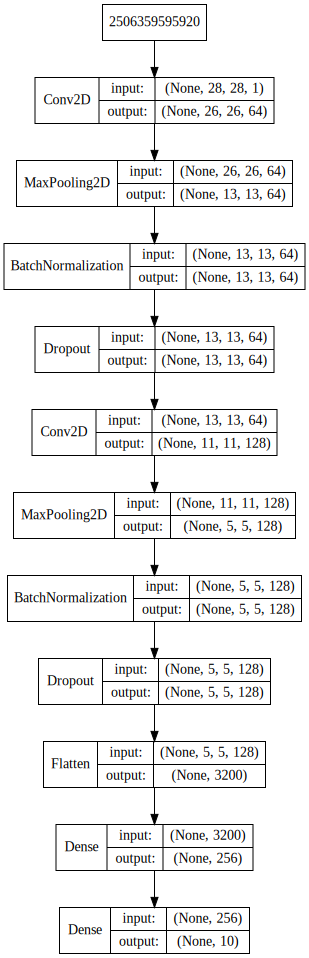

In [16]:
#explore model
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

In [13]:
#fit
history = model.fit(x, y,
          batch_size=128,
          epochs=3,
          verbose=1,
          validation_data=(x_dev, y_dev)
         )
         
score = model.evaluate(x_dev, y_dev, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 39900 samples, validate on 2100 samples
Epoch 1/3
39900/39900 [==============================] - 89s 2ms/step - loss: 0.1507 - acc: 0.9558 - val_loss: 0.0859 - val_acc: 0.9705
Epoch 2/3
39900/39900 [==============================] - 93s 2ms/step - loss: 0.0505 - acc: 0.9844 - val_loss: 0.0696 - val_acc: 0.9790
Epoch 3/3
39900/39900 [==============================] - 87s 2ms/step - loss: 0.0333 - acc: 0.9898 - val_loss: 0.0333 - val_acc: 0.9919
Test loss: 0.0333147111670613
Test accuracy: 0.991904761904762


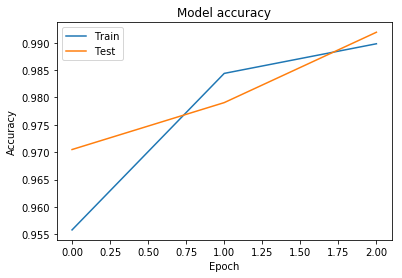

In [14]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

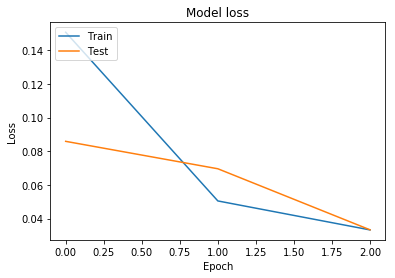

In [15]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# submit to kaggle
y_test = model.predict(x_test)
y_test = np.argmax(y_test, axis=1).astype(int)
y_test = pd.DataFrame({"ImageId": np.arange(y_test.shape[0])+1,"Label": y_test})
print(y_test.head())
y_test.to_csv("kaggle_submission.csv", sep=",", index=False)